In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl, get_params_from_rot_and_transl
from params_est import optim_step_ICP, optim_step_neighbors

In [117]:
ksize = 10
depth_dir = f'../data/synthetic/stylized-ww01-plane/blender_renders_depth4_3x_more_frames_mblur_{ksize}/'
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/K_0.txt'

In [118]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [119]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [120]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [121]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)

In [ ]:
depth[0].min(), depth[0].max()

In [ ]:
depth[1].min(), depth[1].max()

In [ ]:
depth.shape, extr.shape, gt_depth.shape

### Testing visualization

In [3]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

NameError: name 'depth' is not defined

In [12]:
pc1.points

tensor([[ 1.6526, -0.7546, 14.1700],
        [ 1.6093, -0.7325, 13.7550],
        [ 1.5657, -0.7103, 13.3393],
        ...,
        [ 0.0976,  1.6636, 13.0099],
        [ 0.1087,  1.7655, 13.8064],
        [ 0.1205,  1.8673, 14.6023]], dtype=torch.float64)

In [122]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [15]:
visualize_pcd(pc1)

### Testing params estimation (ICP correspondence set till convergence + LM till convergence)

In [38]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)

In [39]:
# pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [40]:
visualize_pcd(pc0, pc1)

In [41]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

  0%|          | 0/100 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


  0%|          | 0/100 [00:01<?, ?it/s]


tensor([-1.8034,  0.0841, -0.0755,  0.0127,  0.2649,  0.0294],
       dtype=torch.float64)

In [42]:
visualize_pcd(pc0, pc1)

In [35]:
transl

tensor([-0.3203,  0.5003,  0.1535], dtype=torch.float64)

In [43]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0274,  0.2620, -1.8034],
        [ 0.0307,  0.9995, -0.0087,  0.0841],
        [-0.2616,  0.0164,  0.9650, -0.0755],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [44]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### Testing params estimation ((ICP correspondence set 1 iteration + LM 1 iteration) x N_iter)

In [52]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)

In [53]:
# pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [54]:
# visualize_pcd(pc0, pc1)

In [55]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [56]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [57]:
gradslam_iter = 100

T = torch.eye(4).double()
for i in tqdm(range(gradslam_iter)):
    params_upd = optim_step_neighbors(pc0, pc1, max_iter=1, neighbors_take_each=1000, verbose=0)
    transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
    rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)
    
    T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
    T = T_upd @ T
    rot, transl = T[:3, :3], T[:3, 3]
    params = get_params_from_rot_and_transl(rot, transl)
    # print('loss', loss_T(T, extr[0], extr[1]))
    print('loss', loss_params(params, extr[0], extr[1]))

params









  0%|          | 0/100 [00:00<?, ?it/s]

Correspondence set estimation...










  1%|          | 1/100 [00:02<04:37,  2.80s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(2.7553, dtype=torch.float64)
Correspondence set estimation...










  2%|▏         | 2/100 [00:04<04:15,  2.60s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(2.3214, dtype=torch.float64)
Correspondence set estimation...










  3%|▎         | 3/100 [00:07<03:57,  2.45s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(2.0223, dtype=torch.float64)










  4%|▍         | 4/100 [00:08<03:34,  2.24s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.8298, dtype=torch.float64)
Correspondence set estimation...










  5%|▌         | 5/100 [00:10<03:22,  2.13s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.6871, dtype=torch.float64)
Correspondence set estimation...










  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.5544, dtype=torch.float64)
Correspondence set estimation...










  7%|▋         | 7/100 [00:14<03:14,  2.09s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.4595, dtype=torch.float64)
Correspondence set estimation...










  8%|▊         | 8/100 [00:16<03:10,  2.07s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.3752, dtype=torch.float64)










  9%|▉         | 9/100 [00:18<03:05,  2.04s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.2830, dtype=torch.float64)










 10%|█         | 10/100 [00:20<02:57,  1.97s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.2182, dtype=torch.float64)
Correspondence set estimation...










 11%|█         | 11/100 [00:22<02:54,  1.96s/it]

Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.1152, dtype=torch.float64)










 12%|█▏        | 12/100 [00:24<02:48,  1.92s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(1.0158, dtype=torch.float64)










 13%|█▎        | 13/100 [00:26<02:43,  1.88s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.9170, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.










 14%|█▍        | 14/100 [00:28<02:42,  1.89s/it]

loss tensor(0.8043, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.










 15%|█▌        | 15/100 [00:30<02:43,  1.92s/it]

loss tensor(0.6438, dtype=torch.float64)










 16%|█▌        | 16/100 [00:31<02:41,  1.92s/it]

Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.5252, dtype=torch.float64)


KeyboardInterrupt: 

In [89]:
gradslam_iter = 30

T = torch.eye(4).double()
for i in tqdm(range(gradslam_iter)):
    params_upd = optim_step_ICP(pc0, pc1, max_iter=10, icp_max_iter=1, verbose=0)
    transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
    rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)
    
    T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
    T = T_upd @ T
    rot, transl = T[:3, :3], T[:3, 3]
    params = get_params_from_rot_and_transl(rot, transl)
    # print('loss', loss_T(T, extr[0], extr[1]))
    print('loss', loss_params(params, extr[0], extr[1]))

params









  0%|          | 0/30 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...










  3%|▎         | 1/30 [00:07<03:43,  7.71s/it]

Did not converge with required tolerance.
loss tensor(1.6056, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










  7%|▋         | 2/30 [00:13<03:17,  7.04s/it]

loss tensor(0.6756, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 10%|█         | 3/30 [00:17<02:48,  6.25s/it]

loss tensor(0.0787, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 13%|█▎        | 4/30 [00:20<02:18,  5.31s/it]

loss tensor(0.0166, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 17%|█▋        | 5/30 [00:24<01:58,  4.76s/it]

Did not converge with required tolerance.
loss tensor(0.0085, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 20%|██        | 6/30 [00:27<01:43,  4.33s/it]

Did not converge with required tolerance.
loss tensor(0.0056, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 23%|██▎       | 7/30 [00:30<01:32,  4.01s/it]

Did not converge with required tolerance.
loss tensor(0.0039, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 27%|██▋       | 8/30 [00:33<01:22,  3.75s/it]

Did not converge with required tolerance.
loss tensor(0.0028, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 30%|███       | 9/30 [00:36<01:13,  3.51s/it]

Did not converge with required tolerance.
loss tensor(0.0021, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 33%|███▎      | 10/30 [00:39<01:06,  3.35s/it]

Did not converge with required tolerance.
loss tensor(0.0016, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 37%|███▋      | 11/30 [00:42<01:01,  3.24s/it]

Did not converge with required tolerance.
loss tensor(0.0013, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 40%|████      | 12/30 [00:45<00:56,  3.12s/it]

Did not converge with required tolerance.
loss tensor(0.0011, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 43%|████▎     | 13/30 [00:48<00:51,  3.02s/it]

Did not converge with required tolerance.
loss tensor(0.0010, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 47%|████▋     | 14/30 [00:51<00:48,  3.05s/it]

Did not converge with required tolerance.
loss tensor(0.0009, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 50%|█████     | 15/30 [00:54<00:45,  3.03s/it]

Did not converge with required tolerance.
loss tensor(0.0008, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 53%|█████▎    | 16/30 [00:57<00:43,  3.11s/it]

Did not converge with required tolerance.
loss tensor(0.0008, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 57%|█████▋    | 17/30 [01:00<00:40,  3.10s/it]

Did not converge with required tolerance.
loss tensor(0.0008, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 60%|██████    | 18/30 [01:03<00:36,  3.01s/it]

Did not converge with required tolerance.
loss tensor(0.0008, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 63%|██████▎   | 19/30 [01:06<00:32,  2.97s/it]

Did not converge with required tolerance.
loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 67%|██████▋   | 20/30 [01:09<00:29,  2.94s/it]

Did not converge with required tolerance.
loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 70%|███████   | 21/30 [01:12<00:26,  2.92s/it]

Did not converge with required tolerance.
loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 73%|███████▎  | 22/30 [01:15<00:23,  2.93s/it]

Did not converge with required tolerance.
loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 77%|███████▋  | 23/30 [01:18<00:20,  2.93s/it]

Did not converge with required tolerance.
loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 80%|████████  | 24/30 [01:21<00:17,  2.95s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 83%|████████▎ | 25/30 [01:24<00:14,  2.96s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 87%|████████▋ | 26/30 [01:27<00:11,  2.95s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 90%|█████████ | 27/30 [01:30<00:08,  2.96s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 93%|█████████▎| 28/30 [01:32<00:05,  2.89s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










 97%|█████████▋| 29/30 [01:35<00:02,  2.81s/it]

loss tensor(0.0007, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...










100%|██████████| 30/30 [01:38<00:00,  3.27s/it]

loss tensor(0.0007, dtype=torch.float64)


tensor([-1.8059,  0.0833, -0.0752,  0.0126,  0.2652,  0.0296],
       dtype=torch.float64)

In [69]:
params_upd

tensor([-1.8034,  0.0841, -0.0755,  0.0127,  0.2649,  0.0294],
       dtype=torch.float64)

In [70]:
T

tensor([[ 1.0000e+00, -5.1284e-05,  1.0130e-04, -8.1367e-04],
        [ 5.1281e-05,  1.0000e+00,  2.8167e-05, -1.3504e-04],
        [-1.0130e-04, -2.8162e-05,  1.0000e+00, -6.1667e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)

In [ ]:
T

In [68]:
visualize_pcd(pc0, pc1)

In [51]:
transl

tensor([-8.1367e-04, -1.3504e-04, -6.1667e-05], dtype=torch.float64)

In [71]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 1.0000e+00, -5.1284e-05,  1.0130e-04, -8.1367e-04],
        [ 5.1281e-05,  1.0000e+00,  2.8167e-05, -1.3504e-04],
        [-1.0130e-04, -2.8162e-05,  1.0000e+00, -6.1667e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)

In [38]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [39]:
rot, transl

(tensor([[ 0.9647, -0.0274,  0.2620],
         [ 0.0307,  0.9995, -0.0087],
         [-0.2616,  0.0164,  0.9650]], dtype=torch.float64),
 tensor([-1.8034,  0.0841, -0.0755], dtype=torch.float64))

In [40]:
params

tensor([-1.8034,  0.0841, -0.0755,  0.0127,  0.2649,  0.0294],
       dtype=torch.float64)

In [41]:
gt_rel_extr = extr[1] @ torch.inverse(extr[0])
get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])

tensor([-1.8127,  0.0583, -0.0723,  0.0084,  0.2662,  0.0244],
       dtype=torch.float64)

### GradOdometry

In [100]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = gt_depth[1].clone()
_ = depth_first.requires_grad_()

In [101]:
depth.shape

torch.Size([2, 1080, 1920])

In [102]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [103]:
gt_pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
gt_pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [104]:
# pc0.mask = gt_pc0.mask
# pc1.mask = gt_pc1.mask
# pc0.update_data(pc0.depth, pc0.intrinsic, pc0.extrinsic, update_mask=False)
# pc0.update_data(pc1.depth, pc1.intrinsic, pc1.extrinsic, update_mask=False)

In [105]:
visualize_pcd(pc0, pc1)

In [106]:
def loss(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

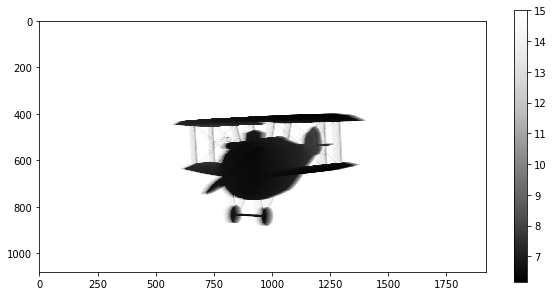














  0%|          | 0/30 [00:00<?, ?it/s]

L1 between depth_first pic with motion blur and GT: 0.09032100476048611
Correspondence set estimation...
Extrinsics estimation...
loss tensor(1.7148, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
loss tensor(2.0855, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
loss tensor(3.0321, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...


KeyboardInterrupt: 

In [108]:
gradslam_iter = 30
internal_iter = 5
opt = optim.Adam([depth_first], lr=3e-3)

depth_history = []
loss_history = []
internal_loss_history = []

depth_first_img = depth_first.cpu().data.numpy()
depth_first_img_gt = gt_depth[0].cpu().data.numpy()
depth_history.append(depth_first_img)
plt.figure(figsize=(10, 5))
plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.show()
print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
# print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))


for i in tqdm(range(gradslam_iter)):
    pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    T = torch.eye(4).double()
    for j in range(internal_iter):
        params_upd = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=1, verbose=0)
        # params_upd = optim_step_neighbors(pc0, pc1, max_iter=100, neighbors_take_each=1000, verbose=0)
        transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
        rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
        pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)

        T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
        T = T_upd @ T
        rot, transl = T[:3, :3], T[:3, 3]
        params = get_params_from_rot_and_transl(rot, transl)
        # print('loss', loss_T(T, extr[0], extr[1]))
        loss_val = loss_params(params, extr[0], extr[1]).detach()
        internal_loss_history.append(loss_val.item())
        print('loss', loss_val)
    
    opt.zero_grad()
    loss_val = loss_params(params, extr[0], extr[1])
    loss_history.append(loss_val.item())
    print('loss', loss_val)
    loss_val.backward()
    opt.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
    plt.colorbar()
    plt.show()
    print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
#     print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))

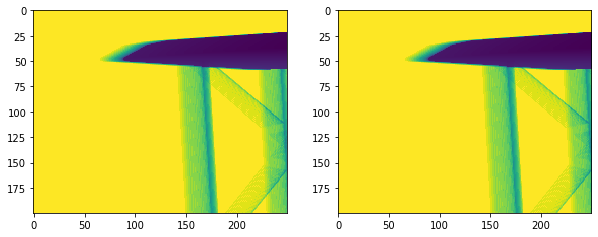

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(depth_history[0][400:600, 500:750])
ax[1].imshow(depth_history[-1][400:600, 500:750])

In [110]:
depth_history[0].min(), depth_history[0].max()

(6.218850410019954, 15.0)

In [111]:
depth_first.min(), depth_first.max()

(tensor(6.2189, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [112]:
depth_first_img_gt.min(), depth_first_img_gt.max()

(6.15234375, 15.0)

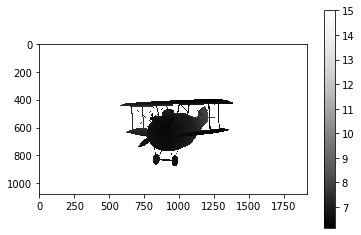

In [56]:
plt.imshow(depth_first_img_gt, cmap=plt.cm.Greys_r)
plt.colorbar()